<a href="https://colab.research.google.com/github/artembakhanov/simulated-annealing-salesman-russia/blob/main/stat_assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STDSR Assignment 3
**Author: Artem Bakhanov ([email](mailto:a.bahanov@innopolis.university))**

[GitHub repository](https://github.com/artembakhanov/simulated-annealing-salesman-russia)

## Download dataset and dependencies

In [ ]:
from IPython.display import clear_output
!pip install geopandas
!git clone https://github.com/hflabs/city
%cp city/city.csv city.csv

clear_output()

## Simulated Annealing Implementation
This is the general implementation of the simulated annealing algorithm.
It takes several paramers: initial value, function to optimize, proposal function (generates next steps), and algorithm parameters such as decay and final temperature.

In [2]:
import numpy as np

In [57]:
def anneal(
    x0, 
    func, 
    proposal_func, 
    decay=0.99, 
    T0=1, 
    Tf = 0.1, 
    reduce_steps=1, 
    maxiter=1000,
    args = {}):
  """
  An optimization method based on Simulated Annealing.

  Args:
    x0 (int): Starting value.
    func ((int, **args) -> numeric): Function to optimize.
    proposal_func ((x, t, T) -> x'): Function used to propose new values.
    decay (float): Geometric series rate of decay.
    T0 (float): Starting value of temperature.
    Tf (float): Temperature after achieving which the optimization stops.
    reduce_steps (int): Amount of steps after which the temperature is decreased.
    maxiter (int): Maximum number of cooling steps after which the optimization
                   stops.
    args (dict): Arguments to pass to func.

  """
  t = 0
  # step 1. Initial value
  x = x0
  # step 2. Initial temperature
  T = T0

  accepted = [(t, T, func(x0), x0)]

  while True:
    # step 3. Sample x' from proposal function
    x_ = proposal_func(x, t, T)
    # step 4. Calculate acceptance ratio
    a = np.exp(-func(x_) / T, **args) / np.exp(-func(x) / T)
    # step 5.1. Generate u ~ U(0, 1)
    u = np.random.uniform()
    # step 5.2. If u <= a, accept
    if u <= a:
      x = x_
      accepted.append((t, T, func(x), x))

    # step 6. Anneal the temperature
    if t % reduce_steps == reduce_steps - 1:
      T = T * decay
    # step 7. Increment time
    t += 1
    # step 8. Repeat 3-8
    if t // reduce_steps >= maxiter or T <= Tf:
      break

  return x, func(x), T, accepted

## Salesman Problem Solution on Russian Cities

In [4]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from geographiclib.geodesic import Geodesic
from geopy.distance import geodesic

Read the cities data and select 30 most populated cites. Remove 
unnecessary data from the dataset.

In [7]:
cities = pd.read_csv("city.csv")
cities = cities.sort_values('population', ascending=False).head(30)
cities = cities.reset_index()[['address', 'geo_lat', 'geo_lon', 'population']]

In [8]:
cities.head()

address    geo_lat    geo_lon  population
0           г Москва  55.754047  37.620405    11514330
1  г Санкт-Петербург  59.939131  30.315900     4848742
2      г Новосибирск  55.028191  82.921149     1498921
3     г Екатеринбург  56.838522  60.605491     1377738
4  г Нижний Новгород  56.324063  44.005391     1250615

In [9]:
cities_ = cities
cities = cities.to_dict('records')

Calculate distances between the cities

In [10]:
dists = {i: {} for i in range(len(cities))}

for i, city0 in enumerate(cities):
  coord0 = (city0["geo_lat"], city0["geo_lon"])
  for j, city1 in enumerate(cities):
    coord1 = (city1["geo_lat"], city1["geo_lon"])
    dist = geodesic(coord0, coord1).km
    dists[i][j] = dist
    dists[j][i] = dist

**Energy function**

This is the function to be optimized. In our case it is the total length of the
looped path.

In [11]:
def dist(path):
  d = 0
  for i, city in enumerate(path):
    d += dists[city][path[i - 1]]
  return d

**Proposal function**

This is the function that will sample that will be accepted or rejected during
one step of simulated annealing.

In [12]:
def propose(prev_path, _t, _T):
  ans = prev_path.copy()
  i0, i1 = np.random.choice(range(len(ans)), 2, replace=False)

  ans[i0], ans[i1] = ans[i1], ans[i0]

  return ans

Let us calculate the shortest way (**the best parameters**)



In [58]:
path, d, T, accepted = anneal(list(range(30)), dist, propose, maxiter=10_000, T0=400, Tf=25, reduce_steps=100)

In [62]:
print(f"The total distance: {d:.02f}km; accepted proposals: {len(accepted)}; final temp: {T}") 

The total distance: 17995.99km; accepted proposals: 1246; final temp: 24.967421911929634


## Animation

In [27]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [65]:
def map_animation(accepted, every=10, interval=25, figsize=(16, 9)):
  russia_gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))  
  russia_gdf = russia_gdf[russia_gdf['name'] == 'Russia']

  fig, ax = plt.subplots(dpi=100, figsize=figsize)
  line, = ax.plot([], [], linewidth = 2, linestyle = "dashdot", color = "red")

  def init():
      ax.set_xlim(10, 140)
      ax.set_ylim(42, 75)
      russia_gdf.plot(color =  '#e3bccf', edgecolor = 'blue', figsize=figsize, ax=ax)

      for x, y, label in zip(russia_gdf.geometry.representative_point().x, russia_gdf.geometry.representative_point().y, russia_gdf.name):
          ax.annotate(label, xy=(x, y))

      for city in cities:
          ax.annotate(city["address"], (city["geo_lon"], city["geo_lat"]))

      russia_gdf.plot(ax=ax, color = 'orange')
      cities_x = [city["geo_lon"] for city in cities]
      cities_y = [city["geo_lat"] for city in cities]
      ax.scatter(cities_x, cities_y, 108)

  def update(frame):
      t, T, d, x = frame
      cities_x = [cities[i]["geo_lon"] for i in x] + [cities[x[0]]["geo_lon"]]
      cities_y = [cities[i]["geo_lat"] for i in x] + [cities[x[0]]["geo_lat"]]
      line.set_data(cities_x, cities_y)
      plt.title(f"t = {t}; T = {T}, dist = {d}")

  frames = accepted[::every]
  ani = FuncAnimation(fig, update, frames=frames,
                      init_func=init, blit=False, interval=interval)

  # ani.save('sine_wave.gif', "pillow", fps=100)
  return HTML(ani.to_html5_video())

CPU times: user 2min 53s, sys: 10.9 s, total: 3min 4s
Wall time: 3min 16s


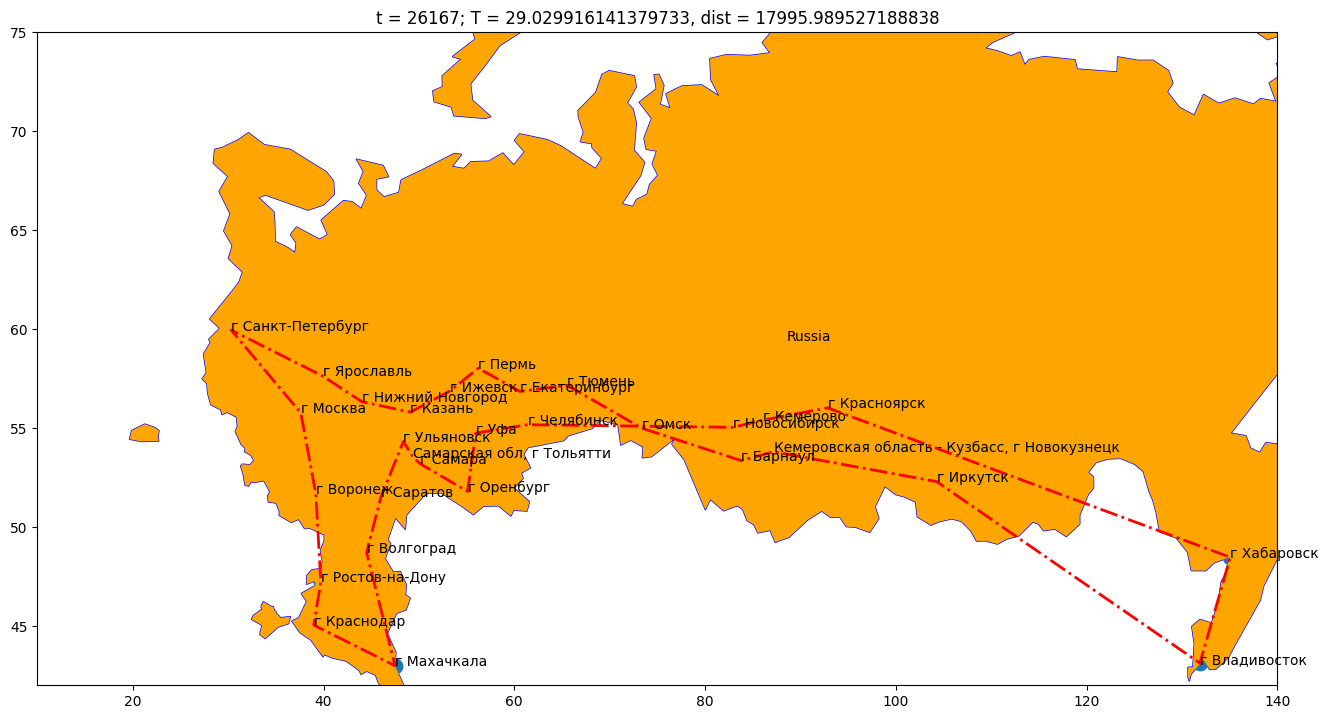

In [67]:
%%time
map_animation(accepted, every=1, interval=20)

### The final image

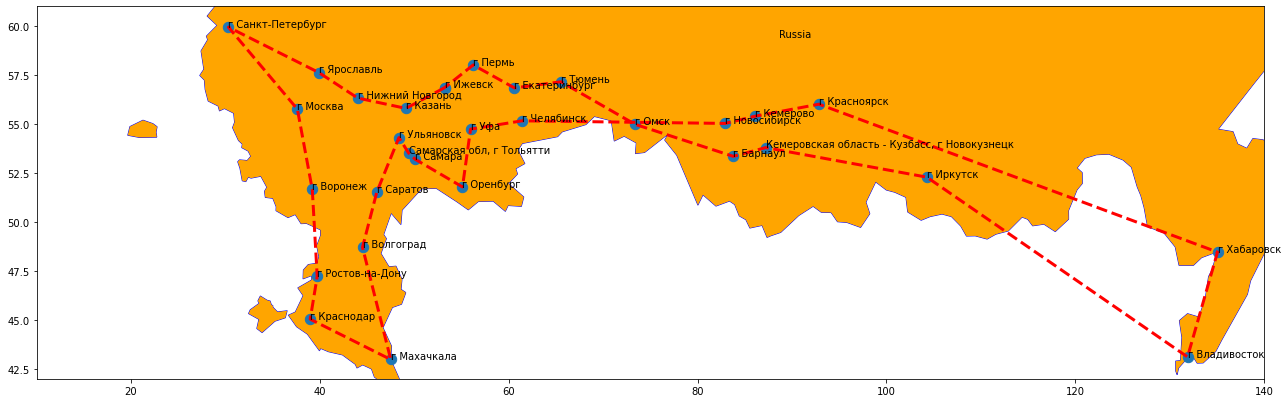

In [69]:
russia_gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))  
russia_gdf = russia_gdf[russia_gdf['name'] == 'Russia']

figsize=[22, 15]

ax = russia_gdf.plot(color =  '#e3bccf', edgecolor = 'blue', figsize=figsize)
plt.xlim([10, 140])
plt.ylim([42, 61])

for x, y, label in zip(russia_gdf.geometry.representative_point().x, russia_gdf.geometry.representative_point().y, russia_gdf.name):
    ax.annotate(label, xy=(x, y))
russia_gdf.plot(ax=ax, color = 'orange')

cities_x = [cities[i]["geo_lon"] for i in path] + [cities[path[0]]["geo_lon"]]
cities_y = [cities[i]["geo_lat"] for i in path] + [cities[path[0]]["geo_lat"]]
plt.plot(cities_x, cities_y, linewidth = 3, linestyle = "--", color = "red")
plt.scatter(cities_x, cities_y, 108)
for i in path:
    ax.annotate(cities[i]["address"], (cities[i]["geo_lon"], cities[i]["geo_lat"]))

plt.show()

## Comparison of different rates

In [77]:
%%time
path_slow, d_slow, T_slow, accepted_slow = anneal(list(range(30)), dist, propose, maxiter=10_000, T0=400, Tf=25, reduce_steps=100, decay=0.99)
path_middle, d_middle, T_middle, accepted_middle = anneal(list(range(30)), dist, propose, maxiter=10_000, T0=400, Tf=25, reduce_steps=75, decay=0.95)
path_fast, d_fast, T_fast, accepted_fast = anneal(list(range(30)), dist, propose, maxiter=10_000, T0=400, Tf=25, reduce_steps=25, decay=0.9)

CPU times: user 2.63 s, sys: 16.9 ms, total: 2.64 s
Wall time: 3.83 s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


In [88]:
def convergence_graph(accepted, title):
  # [(t, T, func(x0), x0)]
  t = [a[0] for a in accepted]
  T = [a[1] for a in accepted]
  d = [a[2] for a in accepted]

  fig, ax1 = plt.subplots()

  color = 'tab:red'
  ax1.set_xlabel('time (step)')
  ax1.set_ylabel('dist (km)', color=color)
  ax1.plot(t, d, color=color)
  ax1.tick_params(axis='y', labelcolor=color)

  ax2 = ax1.twinx()  
  color = 'tab:blue'
  ax2.set_ylabel('Temperature (T)', color=color)  
  ax2.plot(t, T, color=color)
  ax2.tick_params(axis='y', labelcolor=color)

  fig.tight_layout() 
  plt.title(title)
  plt.show()

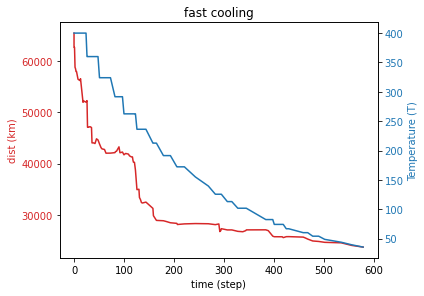

In [89]:
convergence_graph(accepted_fast, "fast cooling")

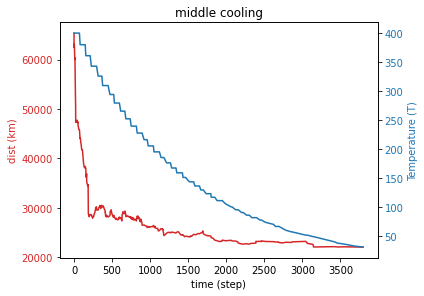

In [90]:
convergence_graph(accepted_middle, "middle cooling")

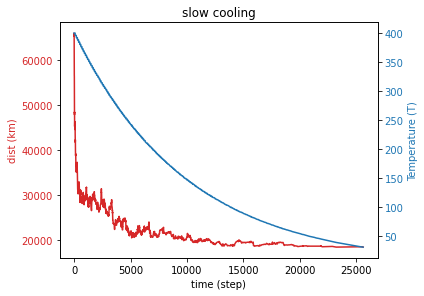

In [92]:
convergence_graph(accepted_slow, "slow cooling")

In [96]:
def calculate_final_dists(N=50, **kwargs):
  ans = 0
  for _ in range(N):
    ans += anneal(list(range(30)), dist, propose, **kwargs)[1]
  
  return ans / N


d_slow_av = calculate_final_dists(maxiter=10_000, T0=400, Tf=25, reduce_steps=100, decay=0.99)
d_middle_av = calculate_final_dists(maxiter=10_000, T0=400, Tf=25, reduce_steps=75, decay=0.95)
d_fast_av = calculate_final_dists(10_000, T0=400, Tf=25, reduce_steps=25, decay=0.9)

print(f"Average Distance (slow): {d_slow_av:.02f}km")
print(f"Average Distance (middle): {d_middle_av:.02f}km")
print(f"Average Distance (fast): {d_fast_av:.02f}km")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


Average Distance (slow): 18431.68km
Average Distance (middle): 19890.65km
Average Distance (fast): 24804.24km


It seems like fast cooling converges faster compared to middle and slow cooling. However, the final result is more optimal in fast and middle coolings. Most probably it happens because the algorithm does not have enough time to find more optimal solution when it is allowed to "explore" (high temperature).

In general, slow cooling converged to smaller distance compared to other two methods.